In [166]:
# Imports for analysis
from smart_open import open as smart_open
import pandas as pd
# import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)

## Parse results log file


In [2]:
LOG_FILE_PATH = "results/CartPole-v1/train-a2c/20210405-225734/all_results.txt"

RESULTS = []
SEPARATOR = "=="

with smart_open(LOG_FILE_PATH, "r", encoding="utf-8", errors="ignore") as f:
    contents = f.readlines()

    # Strip unnecessary/empty new lines
    contents = [line for line in contents if line != "\n"]
    contents = [line for line in contents if not line.startswith(SEPARATOR)]

    enumerated_contents = list(enumerate(contents, 1))

    for _ in range(0, len(enumerated_contents)-1, 4):
        result = {}
        result["datetime"] = enumerated_contents[_][1].split(":")[1]
        result["hyperparameters"] = enumerated_contents[_ + 1][1].split(":", 1)[1]
        result["results"] = enumerated_contents[_ + 2][1].split(":", 1)[1]
        result["wall_time"] = enumerated_contents[_ + 3][1].split(":")[1]

        RESULTS.append(result)        

len(RESULTS)


54

In [148]:
results_df = pd.DataFrame.from_dict(RESULTS)
results_df.head(5)

,datetime,hyperparameters,results,wall_time
0,20210405-225734\n,"num_env:6, num_episodes:50000, learning_rate:0...","min_reward:21.3, max_reward:139.2, reward_vari...",120.04074515500179\n
1,20210405-225734\n,"num_env:6, num_episodes:50000, learning_rate:0...","min_reward:15.1, max_reward:184.4, reward_vari...",126.65153170299891\n
2,20210405-225734\n,"num_env:6, num_episodes:50000, learning_rate:0...","min_reward:15.4, max_reward:202.4, reward_vari...",129.78630696300024\n
3,20210405-225734\n,"num_env:6, num_episodes:50000, learning_rate:0...","min_reward:18.5, max_reward:205.1, reward_vari...",134.3010969499992\n
4,20210405-225734\n,"num_env:6, num_episodes:50000, learning_rate:0...","min_reward:17.0, max_reward:178.5, reward_vari...",130.13781459500024\n


In [149]:
# Strip new lines
results_df["datetime"] = results_df["datetime"].str.strip()
results_df["hyperparameters"] = results_df["hyperparameters"].str.strip()
results_df["results"] = results_df["results"].str.strip()
results_df["results"] = results_df["results"].str.replace("::", ":-") # This is to fix a bad replace bug during logging - negative numbers must be preserved
results_df["wall_time"] = results_df["wall_time"].str.strip()
results_df.head(3)

,datetime,hyperparameters,results,wall_time
0,20210405-225734,"num_env:6, num_episodes:50000, learning_rate:0...","min_reward:21.3, max_reward:139.2, reward_vari...",120.04074515500179
1,20210405-225734,"num_env:6, num_episodes:50000, learning_rate:0...","min_reward:15.1, max_reward:184.4, reward_vari...",126.65153170299891
2,20210405-225734,"num_env:6, num_episodes:50000, learning_rate:0...","min_reward:15.4, max_reward:202.4, reward_vari...",129.78630696300024


In [150]:
# Split items in hyperparameters and results columns into lists
results_df["hyperparameters"] = results_df["hyperparameters"].str.split(",", 3)
results_df["results"] = results_df["results"].str.split(",")
results_df.head(3)

,datetime,hyperparameters,results,wall_time
0,20210405-225734,"[num_env:6, num_episodes:50000, learning_rat...","[min_reward:21.3, max_reward:139.2, reward_v...",120.04074515500179
1,20210405-225734,"[num_env:6, num_episodes:50000, learning_rat...","[min_reward:15.1, max_reward:184.4, reward_v...",126.65153170299891
2,20210405-225734,"[num_env:6, num_episodes:50000, learning_rat...","[min_reward:15.4, max_reward:202.4, reward_v...",129.78630696300024


In [151]:
# Make reliable index column
results_df.reset_index(level=0, inplace=True)

In [152]:
flattened_hyperparameters_df = pd.DataFrame(results_df["hyperparameters"].to_list(), columns=["num_env", "num_episodes", "learning_rate", "hidden_layers"], index=results_df["index"])
flattened_results_df = pd.DataFrame(results_df["results"].to_list(), columns=["min_reward", "max_reward", "reward_variance", "mean_reward", "mean_actor_loss", "mean_critic_loss", "mean_entropy_loss", "mean_overall_loss"], index=results_df["index"])


In [153]:
flattened_hyperparameters_df.reset_index(level=0, inplace=True)
flattened_results_df.reset_index(level=0, inplace=True)

In [154]:
preprocessed_results_df = results_df.join(flattened_hyperparameters_df, on="index", lsuffix="_p")
preprocessed_results_df = preprocessed_results_df.join(flattened_results_df, on="index", lsuffix="_r")
preprocessed_results_df.head(3)


,index_p,datetime,hyperparameters,results,wall_time,index_r,num_env,num_episodes,learning_rate,hidden_layers,index,min_reward,max_reward,reward_variance,mean_reward,mean_actor_loss,mean_critic_loss,mean_entropy_loss,mean_overall_loss
0,0,20210405-225734,"[num_env:6, num_episodes:50000, learning_rat...","[min_reward:21.3, max_reward:139.2, reward_v...",120.04074515500179,0,num_env:6,num_episodes:50000,learning_rate:0.001,"hidden_layers:(32, 32)",0,min_reward:21.3,max_reward:139.2,reward_variance:26.496033589954553,mean_reward:77.29800000000002,mean_actor_loss:-0.11034903979808929,mean_critic_loss:2.3578196430739373,mean_entropy_loss:-3.2299348449707033,mean_overall_loss:2.2442579316822346
1,1,20210405-225734,"[num_env:6, num_episodes:50000, learning_rat...","[min_reward:15.1, max_reward:184.4, reward_v...",126.65153170299891,1,num_env:6,num_episodes:50000,learning_rate:0.001,"hidden_layers:(64, 64)",1,min_reward:15.1,max_reward:184.4,reward_variance:37.07680115651834,mean_reward:90.30400000000002,mean_actor_loss:-0.09831048473428179,mean_critic_loss:1.9740386339361984,mean_entropy_loss:-3.166618962287903,mean_overall_loss:1.8725499991586898
2,2,20210405-225734,"[num_env:6, num_episodes:50000, learning_rat...","[min_reward:15.4, max_reward:202.4, reward_v...",129.78630696300024,2,num_env:6,num_episodes:50000,learning_rate:0.001,"hidden_layers:(128, 128)",2,min_reward:15.4,max_reward:202.4,reward_variance:35.883354135309034,mean_reward:99.63600000000001,mean_actor_loss:-0.10236293252928909,mean_critic_loss:1.819860874202171,mean_entropy_loss:-3.1372220420837404,mean_overall_loss:1.7143505113069666


In [155]:
preprocessed_results_df = preprocessed_results_df.drop(columns=["index_r", "index_p", "hyperparameters", "results"])
preprocessed_results_df.head(2)

,datetime,wall_time,num_env,num_episodes,learning_rate,hidden_layers,index,min_reward,max_reward,reward_variance,mean_reward,mean_actor_loss,mean_critic_loss,mean_entropy_loss,mean_overall_loss
0,20210405-225734,120.04074515500179,num_env:6,num_episodes:50000,learning_rate:0.001,"hidden_layers:(32, 32)",0,min_reward:21.3,max_reward:139.2,reward_variance:26.496033589954553,mean_reward:77.29800000000002,mean_actor_loss:-0.11034903979808929,mean_critic_loss:2.3578196430739373,mean_entropy_loss:-3.2299348449707033,mean_overall_loss:2.2442579316822346
1,20210405-225734,126.65153170299891,num_env:6,num_episodes:50000,learning_rate:0.001,"hidden_layers:(64, 64)",1,min_reward:15.1,max_reward:184.4,reward_variance:37.07680115651834,mean_reward:90.30400000000002,mean_actor_loss:-0.09831048473428179,mean_critic_loss:1.9740386339361984,mean_entropy_loss:-3.166618962287903,mean_overall_loss:1.8725499991586898


In [156]:
_columns = ["index", "datetime", "wall_time", "num_env", "num_episodes", "learning_rate", "hidden_layers", "min_reward", "max_reward", "mean_reward", "reward_variance", "mean_actor_loss", "mean_critic_loss", "mean_entropy_loss", "mean_overall_loss"]

preprocessed_results_df = preprocessed_results_df[_columns]
preprocessed_results_df.head(1)

,index,datetime,wall_time,num_env,num_episodes,learning_rate,hidden_layers,min_reward,max_reward,mean_reward,reward_variance,mean_actor_loss,mean_critic_loss,mean_entropy_loss,mean_overall_loss
0,0,20210405-225734,120.04074515500179,num_env:6,num_episodes:50000,learning_rate:0.001,"hidden_layers:(32, 32)",min_reward:21.3,max_reward:139.2,mean_reward:77.29800000000002,reward_variance:26.496033589954553,mean_actor_loss:-0.11034903979808929,mean_critic_loss:2.3578196430739373,mean_entropy_loss:-3.2299348449707033,mean_overall_loss:2.2442579316822346


In [131]:
preprocessed_results_df.shape

(54, 11)

In [157]:
# Remove text from each column
preprocessed_results_df["min_reward"] = preprocessed_results_df["min_reward"].str.split(":").str[1]
preprocessed_results_df["max_reward"] = preprocessed_results_df["max_reward"].str.split(":").str[1]
preprocessed_results_df["mean_reward"] = preprocessed_results_df["mean_reward"].str.split(":").str[1]
preprocessed_results_df["reward_variance"] = preprocessed_results_df["reward_variance"].str.split(":").str[1]
preprocessed_results_df["mean_actor_loss"] = preprocessed_results_df["mean_actor_loss"].str.split(":").str[1]
preprocessed_results_df["mean_critic_loss"] = preprocessed_results_df["mean_critic_loss"].str.split(":").str[1]
preprocessed_results_df["mean_entropy_loss"] = preprocessed_results_df["mean_entropy_loss"].str.split(":").str[1]
preprocessed_results_df["mean_overall_loss"] = preprocessed_results_df["mean_overall_loss"].str.split(":").str[1]

preprocessed_results_df["num_env"] = preprocessed_results_df["num_env"].str.split(":").str[1]
preprocessed_results_df["num_episodes"] = preprocessed_results_df["num_episodes"].str.split(":").str[1]
preprocessed_results_df["learning_rate"] = preprocessed_results_df["learning_rate"].str.split(":").str[1]
preprocessed_results_df["hidden_layers"] = preprocessed_results_df["hidden_layers"].str.split(":").str[1]

preprocessed_results_df.head(3)

,index,datetime,wall_time,num_env,num_episodes,learning_rate,hidden_layers,min_reward,max_reward,mean_reward,reward_variance,mean_actor_loss,mean_critic_loss,mean_entropy_loss,mean_overall_loss
0,0,20210405-225734,120.04074515500179,6,50000,0.001,"(32, 32)",21.3,139.2,77.29800000000002,26.496033589954553,-0.11034903979808929,2.3578196430739373,-3.2299348449707033,2.2442579316822346
1,1,20210405-225734,126.65153170299891,6,50000,0.001,"(64, 64)",15.1,184.4,90.30400000000002,37.07680115651834,-0.09831048473428179,1.9740386339361984,-3.166618962287903,1.8725499991586898
2,2,20210405-225734,129.78630696300024,6,50000,0.001,"(128, 128)",15.4,202.4,99.63600000000001,35.883354135309034,-0.10236293252928909,1.819860874202171,-3.1372220420837404,1.7143505113069666


In [158]:
# Save results to CSV
preprocessed_results_df.to_csv("training_results_20210405-225734.csv", index=False)

## Analyse training results

In [159]:
training_results_df = pd.read_csv("training_results_20210405-225734.csv")
training_results_df.head(3)

,index,datetime,wall_time,num_env,num_episodes,learning_rate,hidden_layers,min_reward,max_reward,mean_reward,reward_variance,mean_actor_loss,mean_critic_loss,mean_entropy_loss,mean_overall_loss
0,0,20210405-225734,120.040745,6,50000,0.001,"(32, 32)",21.3,139.2,77.298,26.496034,-0.110349,2.357820,-3.229935,2.244258
1,1,20210405-225734,126.651532,6,50000,0.001,"(64, 64)",15.1,184.4,90.304,37.076801,-0.098310,1.974039,-3.166619,1.872550
2,2,20210405-225734,129.786307,6,50000,0.001,"(128, 128)",15.4,202.4,99.636,35.883354,-0.102363,1.819861,-3.137222,1.714351


In [165]:
training_results_df["reward_variance"].describe()

count    54.000000
mean     47.412141
std      11.103552
min      26.496034
25%      39.232841
50%      46.647560
75%      54.323945
max      75.396052
Name: reward_variance, dtype: float64

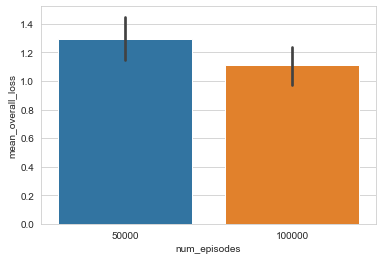

In [196]:
# sns.barplot(data=training_results_df, x="num_episodes", y="reward_variance");
# sns.barplot(data=training_results_df, x="num_episodes", y="max_reward");
# sns.barplot(data=training_results_df, x="num_episodes", y="mean_reward");
sns.barplot(data=training_results_df, x="num_episodes", y="mean_overall_loss");

# Notes: not sure, not very exciting

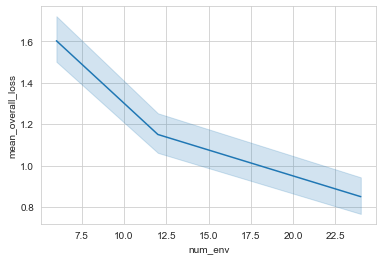

In [195]:
# sns.lineplot(data=training_results_df, x="num_env", y="reward_variance");
# sns.lineplot(data=training_results_df, x="num_env", y="max_reward");
# sns.lineplot(data=training_results_df, x="num_env", y="mean_reward");
sns.lineplot(data=training_results_df, x="num_env", y="mean_overall_loss");

# Notes: High num_envs = lowest overall loss, highest mean and max reward, but highest variance

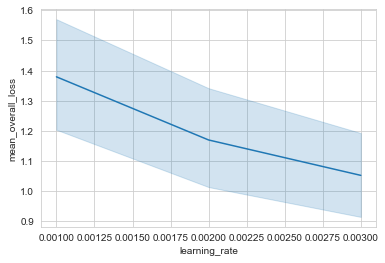

In [202]:
# sns.lineplot(data=training_results_df, x="learning_rate", y="reward_variance");
# sns.lineplot(data=training_results_df, x="learning_rate", y="max_reward");
# sns.lineplot(data=training_results_df, x="learning_rate", y="mean_reward");
sns.lineplot(data=training_results_df, x="learning_rate", y="mean_overall_loss");

# Note: Learning rate seems to have achieved a better loss when it was higher.

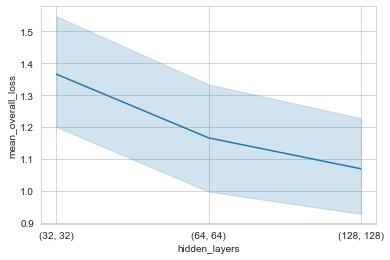

In [208]:
# sns.lineplot(data=training_results_df, x="hidden_layers", y="reward_variance");
# sns.lineplot(data=training_results_df, x="hidden_layers", y="max_reward");
# sns.lineplot(data=training_results_df, x="hidden_layers", y="mean_reward");
sns.lineplot(data=training_results_df, x="hidden_layers", y="mean_overall_loss");

# Note: (128, 128)  didn't seem to be a great return on reducing loss and increasing rewards or consistency of rewards <-- compare wall time

In [211]:
# Understand the min-max or ranges of each column
# Notes: which was the major contributor to mean overall loss? Critic loss. Is that a good thing or bad?
training_results_df.describe()

,index,wall_time,num_env,num_episodes,learning_rate,min_reward,max_reward,mean_reward,reward_variance,mean_actor_loss,mean_critic_loss,mean_entropy_loss,mean_overall_loss
count,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000,54.000000
mean,26.500000,254.146193,14.000000,75000.000000,0.002000,21.538889,254.466667,129.755833,47.412141,-0.060404,1.264170,-3.085134,1.200674
std,15.732133,101.020067,7.553582,25234.746934,0.000824,5.288200,55.314500,25.118622,11.103552,0.038657,0.410469,0.054599,0.379076
min,0.000000,120.040745,6.000000,50000.000000,0.001000,14.000000,139.200000,77.298000,26.496034,-0.121898,0.601505,-3.229935,0.580744
25%,13.250000,166.045827,6.000000,50000.000000,0.001000,17.725000,206.375000,109.437000,39.232841,-0.101660,0.955550,-3.122550,0.909378
50%,26.500000,239.612595,12.000000,75000.000000,0.002000,20.150000,253.100000,134.018000,46.647560,-0.056969,1.215598,-3.087203,1.148685
75%,39.750000,322.239726,24.000000,100000.000000,0.003000,24.975000,295.100000,151.260250,54.323945,-0.020609,1.587016,-3.042439,1.479692
max,53.000000,439.601978,24.000000,100000.000000,0.003000,37.900000,357.400000,177.633000,75.396052,0.004068,2.357820,-2.964169,2.244258


In [209]:
training_results_df.sort_values(by=["mean_overall_loss", "max_reward"], ascending=True).head(5)
training_results_df.sort_values(by=["mean_overall_loss", "mean_reward"], ascending=True).head(5)

,index,datetime,wall_time,num_env,num_episodes,learning_rate,hidden_layers,min_reward,max_reward,mean_reward,reward_variance,mean_actor_loss,mean_critic_loss,mean_entropy_loss,mean_overall_loss
53,53,20210405-225734,423.192914,24,100000,0.003,"(128, 128)",37.9,307.1,140.426,51.644749,-0.017766,0.601505,-2.978573,0.580744
52,52,20210405-225734,426.309445,24,100000,0.003,"(64, 64)",17.7,284.3,151.305,50.402941,-0.019678,0.639909,-3.021798,0.617209
50,50,20210405-225734,433.807385,24,100000,0.002,"(128, 128)",28.8,348.3,161.838,59.924182,-0.020370,0.657104,-3.025075,0.633699
49,49,20210405-225734,439.601978,24,100000,0.002,"(64, 64)",23.2,297.7,177.633,53.911520,-0.022093,0.705993,-3.044573,0.680842
44,44,20210405-225734,225.044123,24,50000,0.003,"(128, 128)",33.8,325.7,163.176,73.750592,-0.015266,0.748057,-3.033696,0.729755
